<h2>Assignment-4</h2>

1. Load & Preprocess the Data

In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Normalizing pixel values to [0, 1]
transform = transforms.ToTensor()

# Download and load the training data
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

images, labels = next(iter(train_loader))
print(f"Image shape: {images.shape}")  # Should be [64, 1, 28, 28]
print(f"Min pixel value: {images.min()}, Max pixel value: {images.max()}")  # Should be in [0.0, 1.0]


Image shape: torch.Size([64, 1, 28, 28])
Min pixel value: 0.0, Max pixel value: 1.0


2. Visualize the Data

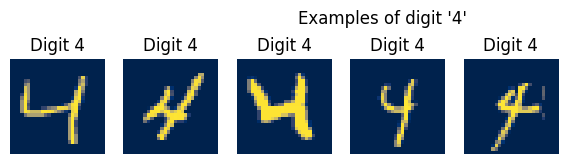

In [ ]:
import matplotlib.pyplot as plt

# Pick the digit to visualize
target_digit = 4

# Collect a few images of the target digit
digit_images = [img for img, label in train_dataset if label == target_digit][:5] 

# Plot the digit images
plt.figure(figsize=(10, 2))
for i, img in enumerate(digit_images):
    plt.subplot(1, 7, i + 1)
    plt.imshow(img.squeeze(), cmap="cividis")
    plt.title(f"Digit {target_digit}")
    plt.axis("off")
plt.suptitle(f"Examples of digit '{target_digit}' ", fontsize=12)
plt.show()


Optional

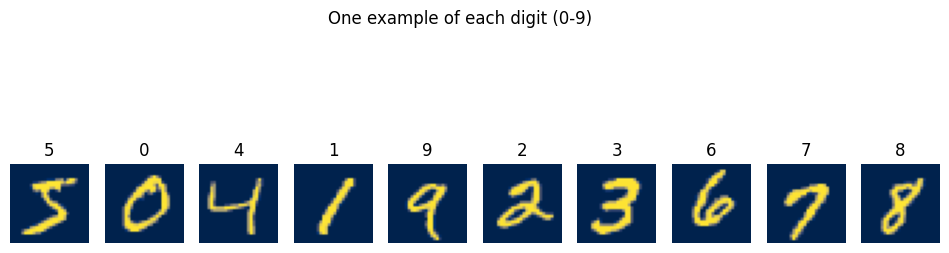

In [ ]:
# Collect one image for each digit
sample_digits = []
seen_labels = set()

for img, label in train_dataset:
    if label not in seen_labels:
        sample_digits.append((img, label))
        seen_labels.add(label)
    if len(seen_labels) == 10:
        break

# Plot one example of each digit
plt.figure(figsize=(12, 4))
for i, (img, label) in enumerate(sample_digits):
    plt.subplot(1, 10, i + 1)
    plt.imshow(img.squeeze(), cmap="cividis")
    plt.title(f"{label}")
    plt.axis("off")
plt.suptitle("One example of each digit (0-9)", fontsize=12)
plt.show()


3. Building CNN 

In [34]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Define CNN Model
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)  # Output: 16x28x28
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # Output: 16x14x14
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)       # Output: 32x14x14 -> pool -> 32x7x7
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)  # Output: 10 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # Conv1 -> ReLU -> Pool
        x = self.pool(F.relu(self.conv2(x)))  # Conv2 -> ReLU -> Pool
        x = x.view(-1, 32 * 7 * 7)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model, loss, optimizer
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

4. Train the Model

In [35]:
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [],[]

def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs=10):
    for epoch in range(1, epochs + 1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        test_loss, test_acc = evaluate(model, test_loader, criterion)

        # Save metrics
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        train_accuracies.append(train_acc)
        test_accuracies.append(test_acc)

        print(f"Epoch {epoch}/{epochs}")
        print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%")
        print(f"  Test  Loss: {test_loss:.4f}, Test  Accuracy: {test_acc:.2f}%\n")
train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, epochs=10)


Epoch 1/10
  Train Loss: 0.2171, Train Accuracy: 93.02%
  Test  Loss: 0.0749, Test  Accuracy: 97.68%

Epoch 2/10
  Train Loss: 0.0850, Train Accuracy: 97.38%
  Test  Loss: 0.0920, Test  Accuracy: 97.24%

Epoch 3/10
  Train Loss: 0.0739, Train Accuracy: 97.73%
  Test  Loss: 0.0767, Test  Accuracy: 97.72%

Epoch 4/10
  Train Loss: 0.0677, Train Accuracy: 97.91%
  Test  Loss: 0.0656, Test  Accuracy: 98.13%

Epoch 5/10
  Train Loss: 0.0629, Train Accuracy: 98.05%
  Test  Loss: 0.0814, Test  Accuracy: 97.77%

Epoch 6/10
  Train Loss: 0.0600, Train Accuracy: 98.11%
  Test  Loss: 0.0739, Test  Accuracy: 97.88%

Epoch 7/10
  Train Loss: 0.0586, Train Accuracy: 98.22%
  Test  Loss: 0.0702, Test  Accuracy: 98.00%

Epoch 8/10
  Train Loss: 0.0609, Train Accuracy: 98.09%
  Test  Loss: 0.0753, Test  Accuracy: 97.83%

Epoch 9/10
  Train Loss: 0.0559, Train Accuracy: 98.27%
  Test  Loss: 0.0851, Test  Accuracy: 97.94%

Epoch 10/10
  Train Loss: 0.0528, Train Accuracy: 98.41%
  Test  Loss: 0.0751, Tes

5. Creating Plots

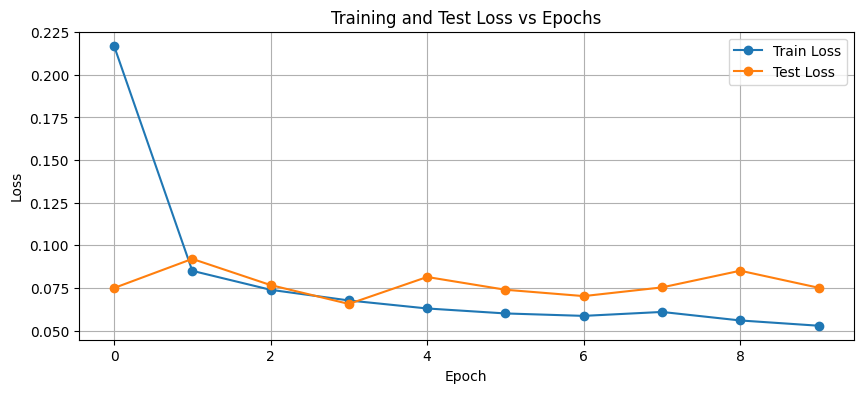

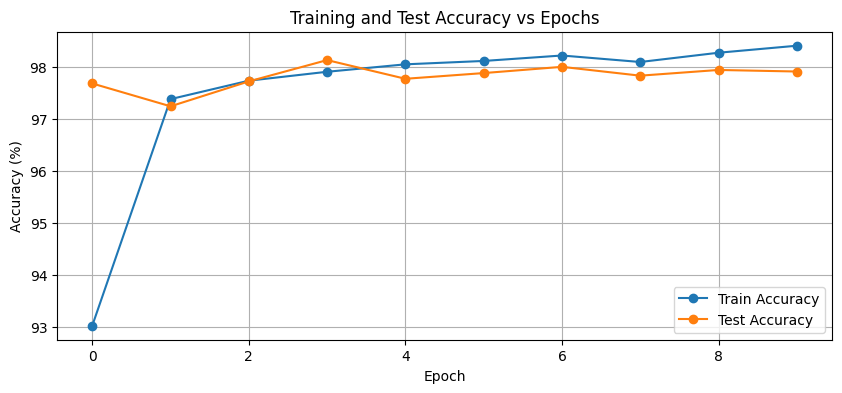

In [38]:
# Plot 1: Loss vs Epochs
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label="Train Loss", marker='o')
plt.plot(test_losses, label="Test Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: Accuracy vs Epochs
plt.figure(figsize=(10, 4))
plt.plot(train_accuracies, label="Train Accuracy", marker='o')
plt.plot(test_accuracies, label="Test Accuracy", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Training and Test Accuracy vs Epochs")
plt.legend()
plt.grid(True)
plt.show()


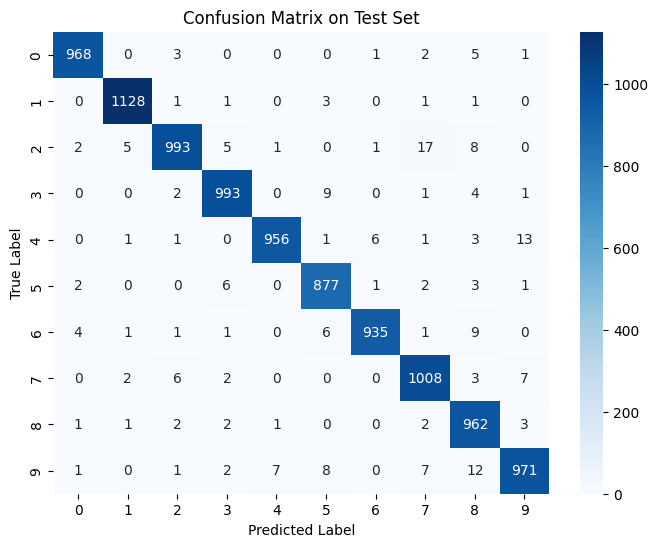

In [39]:
from sklearn.metrics import confusion_matrix

# Collect predictions and labels
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Test Set")
plt.show()
